In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, AveragePooling2D
from keras.optimizers import Adam
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
%matplotlib inline
import json, datetime

In [4]:
#Dataset path
train_dir = '../../Dataset/sedimentary rocks/train'
val_dir = '../../Dataset/sedimentary rocks/test'

In [5]:
# hyperparameters
img_width, img_height = 299, 299
batch_size = 16
epochs = 20

In [6]:
# Data augmentation and preprocessing for the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,  
    vertical_flip=True  
    )
val_datagen = ImageDataGenerator(rescale=1./255,
                                 )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 1212 images belonging to 17 classes.
Found 1212 images belonging to 17 classes.


In [30]:
class_labels = train_generator.class_indices
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_labels)
print(class_labels)
print(num_classes)
print(class_names)

{'Caliche': 0, 'Coquine': 1, 'Dolomitic Limestone': 2, 'Fossiliferous Limestone': 3, 'Limestone': 4, 'Oolitic Limestone': 5, 'Sandstone': 6, 'Shale (Mudstone)': 7, 'Tufa': 8, 'breccia': 9, 'chalk': 10, 'chert': 11, 'coal': 12, 'dolomites': 13, 'flint': 14, 'iron ore': 15, 'siltstone': 16}
17
['Caliche', 'Coquine', 'Dolomitic Limestone', 'Fossiliferous Limestone', 'Limestone', 'Oolitic Limestone', 'Sandstone', 'Shale (Mudstone)', 'Tufa', 'breccia', 'chalk', 'chert', 'coal', 'dolomites', 'flint', 'iron ore', 'siltstone']


In [8]:
#Model
xcep_model = Xception(weights='imagenet', include_top=False)
x = xcep_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(num_classes,activation='softmax')(x)
model = Model(inputs=xcep_model.input, outputs=predictions)

In [9]:
for layer in xcep_model.layers:
    layer.trainable = False

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [11]:
# Model compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=1, 
                               mode='auto')

In [13]:
now = datetime.datetime.now
t = now()
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping])

Epoch 1/20


2023-06-23 18:25:36.772874: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


75/75 [==============================] - 80s 1s/step - loss: 2.3825 - accuracy: 0.3211 - val_loss: 1.9675 - val_accuracy: 0.4083
Epoch 2/20
75/75 [==============================] - 79s 1s/step - loss: 1.7410 - accuracy: 0.4691 - val_loss: 1.3862 - val_accuracy: 0.5467
Epoch 3/20
75/75 [==============================] - 80s 1s/step - loss: 1.5286 - accuracy: 0.5109 - val_loss: 1.2903 - val_accuracy: 0.5742
Epoch 4/20
75/75 [==============================] - 83s 1s/step - loss: 1.5063 - accuracy: 0.5151 - val_loss: 1.1727 - val_accuracy: 0.6183
Epoch 5/20
75/75 [==============================] - 90s 1s/step - loss: 1.3171 - accuracy: 0.5794 - val_loss: 1.1864 - val_accuracy: 0.6192
Epoch 6/20
75/75 [==============================] - 92s 1s/step - loss: 1.2567 - accuracy: 0.5836 - val_loss: 1.0678 - val_accuracy: 0.6458
Epoch 7/20
75/75 [==============================] - 94s 1s/step - loss: 1.1843 - accuracy: 0.6212 - val_loss: 0.9089 - val_accuracy: 0.7108
Epoch 8/20
75/75 [=============

In [14]:
print('Training time: %s' % (now() - t))

Training time: 0:27:41.342394


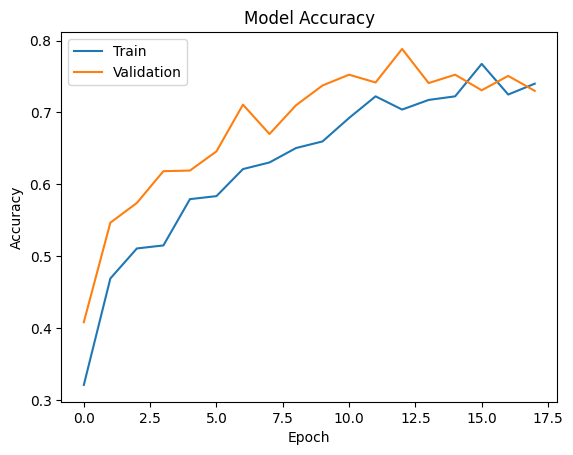

In [15]:
# Visualize training and validation accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

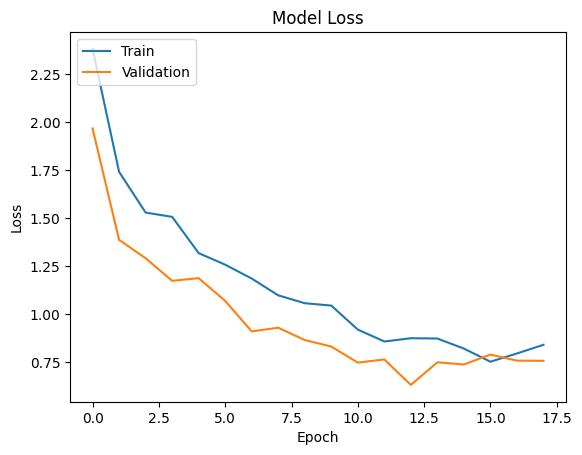

In [16]:
#Visualize training and validation loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print('Accuracy Loss:', val_loss)
print('Accuracy Rating:', val_accuracy)

76/76 [==============================] - 46s 604ms/step - loss: 0.7651 - accuracy: 0.7269
Accuracy Loss: 0.7650908827781677
Accuracy Rating: 0.7268977165222168


In [18]:
# Getting predict and actual labels
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
true_labels = val_generator.classes

76/76 [==============================] - 42s 551ms/step


In [19]:
# Confusion matrixi
cm = confusion_matrix(true_labels, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 13   0   0   0   2   1   0   1   1   0   0   0   0   0   0   0   0]
 [  0  49   0   4   4   0   2   0  10   0   0   0   0   0   0   0   0]
 [  0   0  25   1  15   1   1   1   0   3   1   0   0   0   0   0   0]
 [  0   1   0 201  21  10   3   5  14  17   0   0   0   0   0   0   0]
 [  1   2   1   3  82   2   5   4   8   6   0   0   0   0   0   0   0]
 [  0   1   0  13  14 131  15   3  10   9   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1  44   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   1   0   3  40   1   1   0   0   0   0   0   0   0]
 [  0   0   0   0   3   0   1   0  39   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   1  86   0   0   0   0   0   0   0]
 [  2   0   2   1  14   5   0   3   0   0  19   0   0   0   2   0   0]
 [  1   0   1   1   1   0   1   4   0   0   0  17   0   0   6   0   0]
 [  0   0   1   8   4   3   2   3   1  10   0   0  63   0   2   3   0]
 [  0   0   0   0   2   0   3   1   0   1   0   0   0   5  

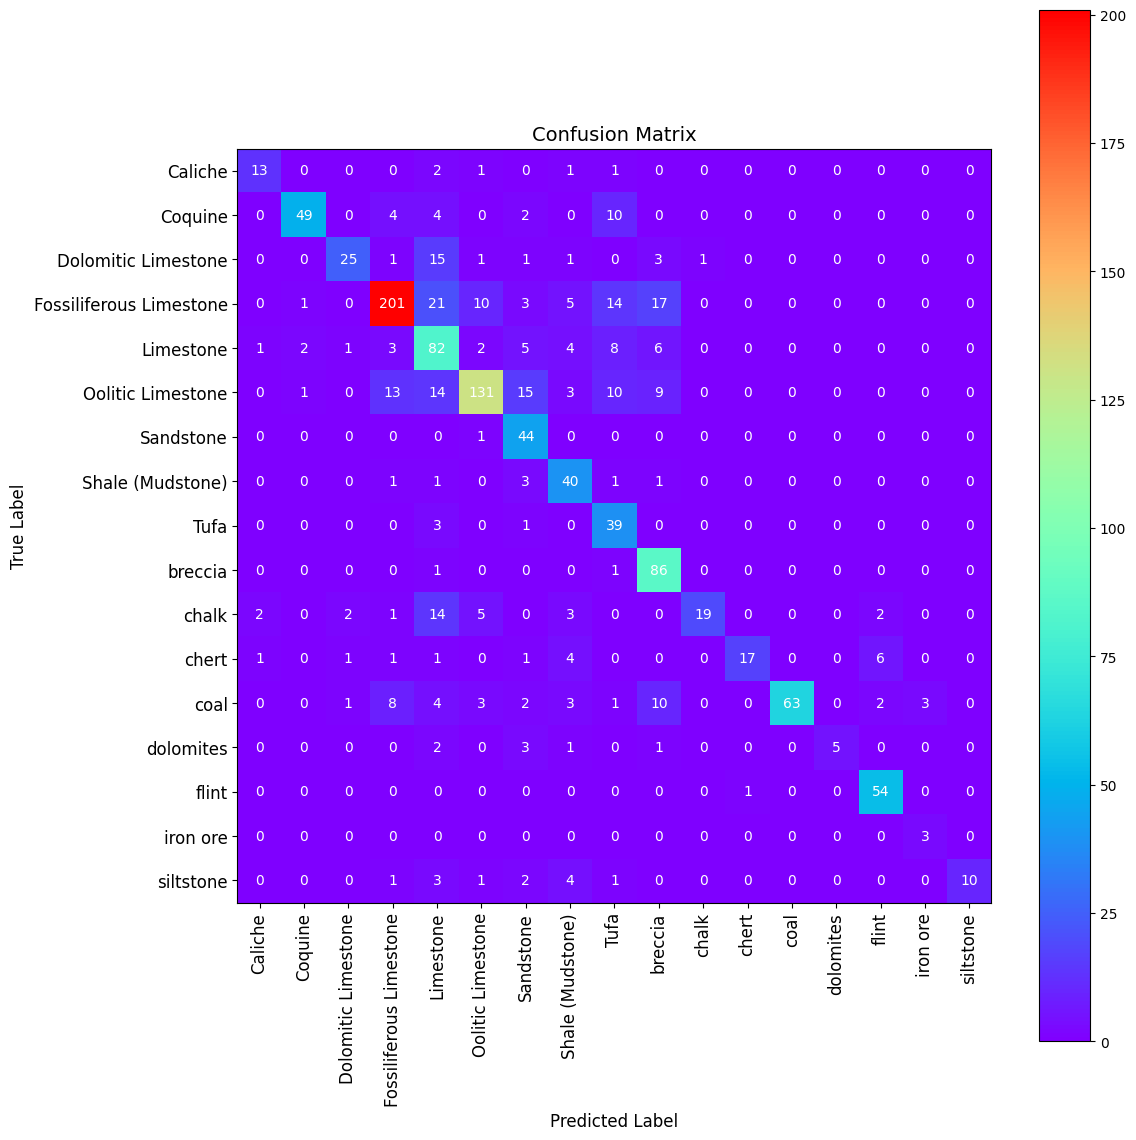

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(cm, cmap='rainbow')

# Renk çubuğu
cbar = plt.colorbar(im)

# Sınıf etiketleri
class_labels = [f'Class {i+1}' for i in range(17)]
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_names, rotation=90, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Grid çizgileri
ax.grid(visible=False)

# Confusion matrix değerlerinin yazdırılması
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.tight_layout()
plt.show()

In [35]:
class_report = classification_report(true_labels, y_pred, target_names=class_names)
print('Class Raport:')
print(class_report)

Class Raport:
                         precision    recall  f1-score   support

                Caliche       0.76      0.72      0.74        18
                Coquine       0.92      0.71      0.80        69
    Dolomitic Limestone       0.83      0.52      0.64        48
Fossiliferous Limestone       0.86      0.74      0.79       272
              Limestone       0.49      0.72      0.58       114
      Oolitic Limestone       0.85      0.67      0.75       196
              Sandstone       0.54      0.98      0.69        45
       Shale (Mudstone)       0.58      0.85      0.69        47
                   Tufa       0.45      0.91      0.60        43
                breccia       0.65      0.98      0.78        88
                  chalk       0.95      0.40      0.56        48
                  chert       0.94      0.53      0.68        32
                   coal       1.00      0.63      0.77       100
              dolomites       1.00      0.42      0.59        12
          

In [36]:
# Save the model and results
model.save('xception_model.h5')
np.save('confusion_matrix.npy', cm)
with open('classification_report.txt', 'w') as f:
    f.write(class_report)

with open("history.json", "w") as f:
    json.dump(history.history, f)